+-------------------+--------------+------------------+
|          Timestamp|Traffic Volume|        prediction|
+-------------------+--------------+------------------+
|2023-01-01 02:00:00|         688.0|  2779.56909581801|
|2023-01-01 06:00:00|        4959.0| 2761.181599299893|
|2023-01-01 08:00:00|        4894.0| 2751.987851040835|
|2023-01-01 13:00:00|        2934.0| 2729.003480393189|
|2023-01-01 19:00:00|        4897.0| 2701.422235616014|
|2023-01-01 23:00:00|        2519.0|2683.0347390978973|
|2023-01-02 05:00:00|        3539.0| 2740.140810774188|
|2023-01-02 11:00:00|        4363.0| 2712.559565997013|
|2023-01-02 21:00:00|        3874.0| 2666.590824701722|
|2023-01-02 22:00:00|        1297.0|2661.9939505721927|
+-------------------+--------------+------------------+
only showing top 10 rows



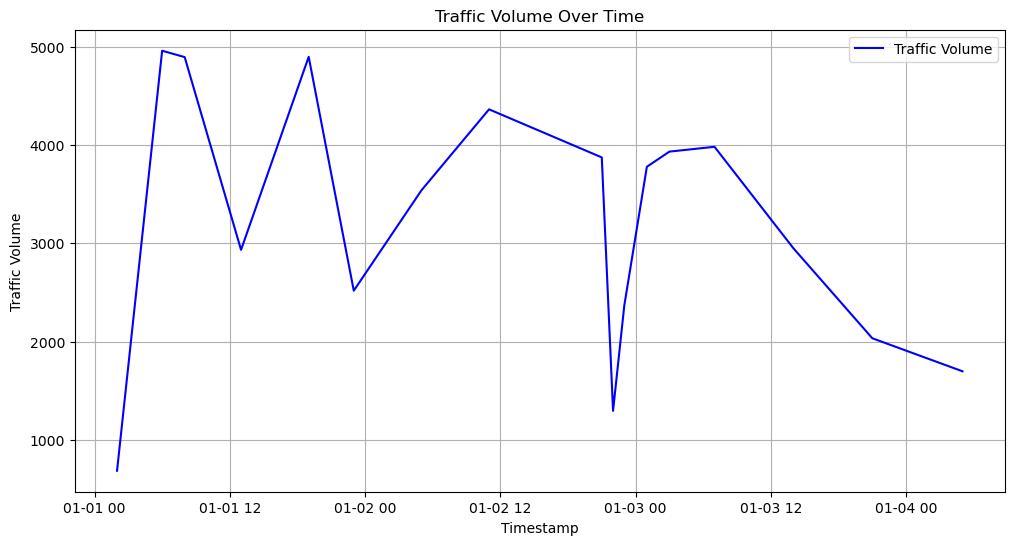

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import BooleanType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()

# Load dataset
df = spark.read.csv("traffic_dataset_with_trend.csv", header=True, inferSchema=True)

# Convert Timestamp to datetime format
df = df.withColumn("Timestamp", to_timestamp(col("Timestamp")))

# Convert Events to boolean
df = df.withColumn("Events", col("Events").cast(BooleanType()))

# Convert Traffic Volume to double
df = df.withColumn("Traffic Volume", col("Traffic Volume").cast(DoubleType()))

# Select relevant columns
df = df.select("Timestamp", "Traffic Volume")

# Feature Engineering: Extract time-based features
df = df.withColumn("Hour", col("Timestamp").substr(12, 2).cast("int"))
df = df.withColumn("Day", col("Timestamp").substr(9, 2).cast("int"))
df = df.withColumn("Month", col("Timestamp").substr(6, 2).cast("int"))
df = df.withColumn("Year", col("Timestamp").substr(1, 4).cast("int"))

# Assemble features
vector_assembler = VectorAssembler(inputCols=["Hour", "Day", "Month", "Year"], outputCol="features")
df = vector_assembler.transform(df)

# Train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Traffic Volume")
model = lr.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

# Show predictions
predictions.select("Timestamp", "Traffic Volume", "prediction").show(10)

# Convert to Pandas for plotting
pdf = predictions.select("Timestamp", "Traffic Volume").toPandas()

# Plot Traffic Volume over Time
plt.figure(figsize=(12, 6))
plt.plot(pdf["Timestamp"], pdf["Traffic Volume"], label="Traffic Volume", color="blue")
plt.xlabel("Timestamp")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Over Time")
plt.legend()
plt.grid()
plt.show()
spark.stop()



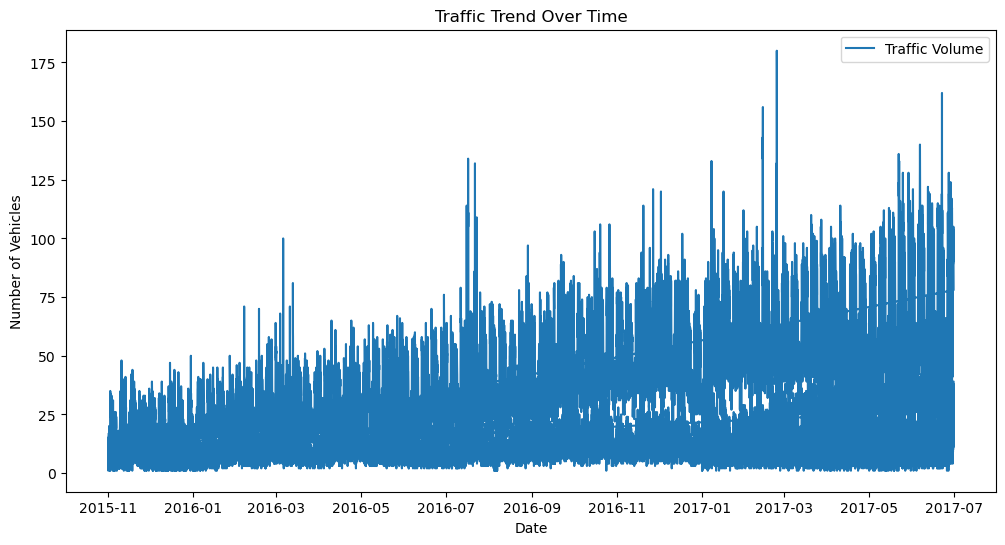

18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing


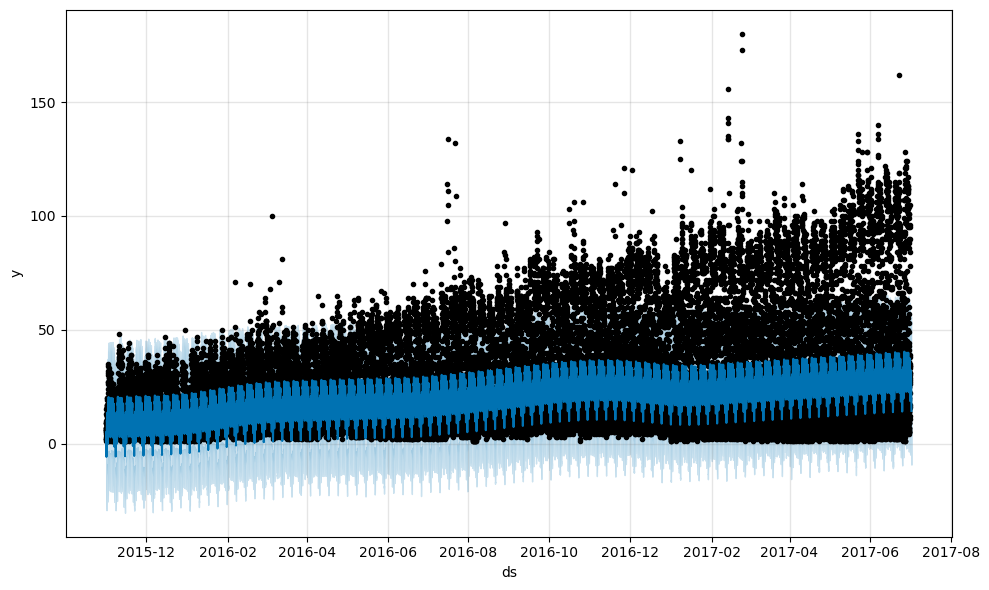

                       ds       yhat  yhat_lower  yhat_upper
14612 2017-07-01 20:00:00  31.929397    8.646810   55.102811
14613 2017-07-01 21:00:00  31.240549    7.157804   55.716700
14614 2017-07-01 22:00:00  29.887637    5.375910   52.189104
14615 2017-07-01 23:00:00  27.820340    2.818728   53.777662
14616 2017-07-02 00:00:00  25.102396    0.873913   48.865449
14617 2017-07-02 01:00:00  22.025813   -1.193300   43.808513
14618 2017-07-02 02:00:00  19.057585   -2.493412   41.553601
14619 2017-07-02 03:00:00  16.639160   -6.557295   41.230332
14620 2017-07-02 04:00:00  15.026249   -9.276141   38.666409
14621 2017-07-02 05:00:00  14.318072   -9.271304   37.364083


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet  # Install with: pip install prophet
 
df = pd.read_csv("traffic.csv")  
 
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.rename(columns={"DateTime": "ds", "Vehicles": "y"})  # Prophet requires 'ds' (date) and 'y' (target)
 
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Traffic Volume")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.title("Traffic Trend Over Time")
plt.legend()
plt.show()
 
model = Prophet()
model.fit(df)

# Make future predictions (next 30 days)
future = model.make_future_dataframe(periods=30, freq="H")  # Predict for next 30 hours
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()

# Show forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))  # Last 10 predictions

